In [1]:
!pip install plotly

In [2]:
!pip install pymc3==3.11.4

In [3]:
import os
os.environ["THEANO_FLAGS"] = "blas__ldflags="

In [7]:
os.environ["MKL_THREADING_LAYER"] = "GNU"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
import seaborn as sns
color = sns.color_palette()
import plotly.express          as ex
import plotly.graph_objs       as go
import plotly.offline          as pyo
import scipy.stats             as stats
import pymc3                   as pm
import theano.tensor           as tt
from matplotlib.colors import ListedColormap
from scipy.stats import norm, boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter
from scipy import stats
from tqdm import tqdm_notebook

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, accuracy_score
from sklearn.model_selection import (GridSearchCV, KFold, train_test_split, cross_val_score)

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
# from catboost import CatBoostClassifier

### Importing The Dataset

In [5]:
path = "water_potability.csv"
df = pd.read_csv(path)

## Initial Analysis

In [6]:
df.shape

(3276, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Except Target feature, other features are float and continueous value. we can convert the Portability into Categoring feature

In [8]:
df.nunique()

ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2
dtype: int64

In [9]:
df['Potability']=df['Potability'].astype('category')

### Statistical Analysis

In [10]:
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
ph,2785.000000,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.000000,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.000000,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.000000,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.000000,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.000000,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.000000,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.000000,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.000000,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000


From the above table, we can see that the count of each feature are not same. so there must me some null values. Feature Solids has the high mean and standard deviation comparted to other feature. so the distribution must be high. However, the above description is for overall population. lets try the same for 2 samples based on Portability feature


In [11]:
#Portability is 1 - means good for Human
df[df['Potability']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
ph,1101.000000,7.073783,1.448048,0.227499,6.179312,7.036752,7.933068,13.175402
Hardness,1278.000000,195.800744,35.547041,47.432000,174.330531,196.632907,218.003420,323.124000
Solids,1278.000000,22383.991018,9101.010208,728.750830,15668.985035,21199.386614,27973.236446,56488.672413
Chloramines,1278.000000,7.169338,1.702988,0.352000,6.094134,7.215163,8.199261,13.127000
Sulfate,985.000000,332.566990,47.692818,129.000000,300.763772,331.838167,365.941346,481.030642
Conductivity,1278.000000,425.383800,82.048446,201.619737,360.939023,420.712729,484.155911,695.369528
Organic_carbon,1278.000000,14.160893,3.263907,2.200000,12.033897,14.162809,16.356245,23.604298
Trihalomethanes,1223.000000,66.539684,16.327419,8.175876,56.014249,66.678214,77.380975,124.000000
Turbidity,1278.000000,3.968328,0.780842,1.492207,3.430909,3.958576,4.509569,6.494249


In [12]:
# Portability is 0 - means not good for Human
df[df['Potability']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdBu')

,count,mean,std,min,25%,50%,75%,max
ph,1684.000000,7.085378,1.683499,0.000000,6.037723,7.035456,8.155510,14.000000
Hardness,1998.000000,196.733292,31.057540,98.452931,177.823265,197.123423,216.120687,304.235912
Solids,1998.000000,21777.490788,8543.068788,320.942611,15663.057382,20809.618280,27006.249009,61227.196008
Chloramines,1998.000000,7.092175,1.501045,1.683993,6.155640,7.090334,8.066462,12.653362
Sulfate,1510.000000,334.564290,36.745549,203.444521,311.264006,333.389426,356.853897,460.107069
Conductivity,1998.000000,426.730454,80.047317,181.483754,368.498530,422.229331,480.677198,753.342620
Organic_carbon,1998.000000,14.364335,3.334554,4.371899,12.101057,14.293508,16.649485,28.300000
Trihalomethanes,1891.000000,66.303555,16.079320,0.738000,55.706530,66.542198,77.277704,120.030077
Turbidity,1998.000000,3.965800,0.780282,1.450000,3.444062,3.948076,4.496106,6.739000


Mean and std of almost all features are similar for both samples. there are few differnces in Solids feature. Further analysis using hypothetical testing could help us to identify the significance.

### Check for missing values

<Axes: title={'center': 'Missing Values Per Feature'}>

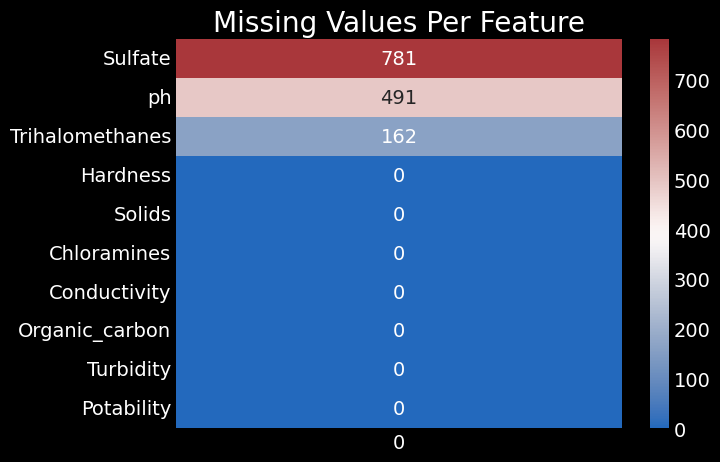

In [13]:
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

In [14]:
df[df['Sulfate'].isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
11,7.974522,218.693300,18767.656682,8.110385,NaN,364.098230,14.525746,76.485911,4.011718,0
14,7.496232,205.344982,28388.004887,5.072558,NaN,444.645352,13.228311,70.300213,4.777382,0
16,7.051786,211.049406,30980.600787,10.094796,NaN,315.141267,20.397022,56.651604,4.268429,0
...,...,...,...,...,...,...,...,...,...,...
3266,8.372910,169.087052,14622.745494,7.547984,NaN,464.525552,11.083027,38.435151,4.906358,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [15]:
df[df['ph'].isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
13,NaN,150.174923,27331.361962,6.838223,299.415781,379.761835,19.370807,76.509996,4.413974,0
20,NaN,227.435048,22305.567414,10.333918,NaN,554.820086,16.331693,45.382815,4.133423,0
22,NaN,215.977859,17107.224226,5.607060,326.943978,436.256194,14.189062,59.855476,5.459251,0
...,...,...,...,...,...,...,...,...,...,...
3224,NaN,198.218700,31081.735264,7.419106,NaN,517.925946,11.711419,85.428785,3.345543,1
3229,NaN,203.204659,10643.186771,6.828936,NaN,384.597711,16.011328,72.911573,3.065910,1
3231,NaN,225.754109,28194.452646,5.892830,366.201583,418.272901,17.306832,103.912548,3.855895,1
3245,NaN,188.536608,24711.414927,7.129520,NaN,555.548534,16.959269,56.038702,4.331691,1


In [16]:
df[df['Trihalomethanes'].isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
62,NaN,229.485694,35729.692709,8.810843,384.943779,296.397547,16.927092,NaN,3.855602,0
81,5.519126,168.728583,12531.601921,7.730723,NaN,443.570372,18.099078,NaN,3.758996,0
110,9.286155,222.661551,12311.268366,7.289866,332.239359,353.740100,14.171763,NaN,5.239982,0
118,7.397413,122.541040,8855.114121,6.888689,241.607532,489.851600,13.365906,NaN,3.149158,0
119,7.812804,196.583886,42550.841816,7.334648,NaN,442.545775,14.666917,NaN,6.204846,0
...,...,...,...,...,...,...,...,...,...,...
3174,6.698154,198.286268,34675.862845,6.263602,360.232834,430.935009,12.176678,NaN,3.758180,1
3185,6.110022,234.800957,16663.539074,5.984536,348.055211,437.892115,10.059523,NaN,2.817780,1
3219,6.417716,209.702425,31974.481631,7.263425,321.382124,289.450118,11.369071,NaN,4.210327,1
3259,9.271355,181.259617,16540.979048,7.022499,309.238865,487.692788,13.228441,NaN,4.333953,1


Since the missing values are on both classess (Potability 1 & 0), we can replace it with population mean. so, we will replace the Nan values bases on sample mean from both classes.


<b> Imputing the missing values with the mean</b>

In [17]:
#################################### Imputing 'ph' value #####################################

phMean_0 = df[df['Potability'] == 0]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['ph'].isna()), 'ph'] = phMean_0
phMean_1 = df[df['Potability'] == 1]['ph'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['ph'].isna()), 'ph'] = phMean_1

##################################### Imputing 'Sulfate' value #####################################

SulfateMean_0 = df[df['Potability'] == 0]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Sulfate'].isna()), 'Sulfate'] = SulfateMean_0
SulfateMean_1 = df[df['Potability'] == 1]['Sulfate'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Sulfate'].isna()), 'Sulfate'] = SulfateMean_1

################################ Imputing 'Trihalomethanes' value #####################################

TrihalomethanesMean_0 = df[df['Potability'] == 0]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 0) & (df['Trihalomethanes'].isna()), 'Trihalomethanes'] = TrihalomethanesMean_0
TrihalomethanesMean_1 = df[df['Potability'] == 1]['Trihalomethanes'].mean(skipna=True)
df.loc[(df['Potability'] == 1) & (df['Trihalomethanes'].isna()), 'Trihalomethanes'] = TrihalomethanesMean_1

In [18]:
print('Checking to see any more missing data \n')
df.isna().sum()

Checking to see any more missing data 



ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

## Exploratory Data Analysis

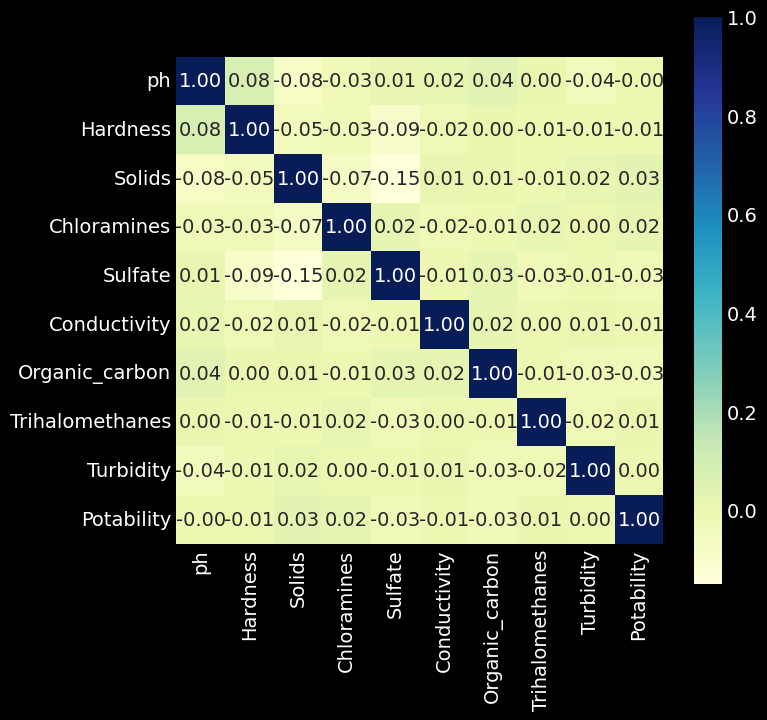

In [19]:
Corrmat = df.corr()
plt.subplots(figsize=(7,7))
sns.heatmap(Corrmat, cmap="YlGnBu", square = True, annot=True, fmt='.2f')
plt.show()

In [20]:
fig =  ex.pie (df, names = "Potability", hole = 0.4, template = "plotly_dark")
fig.show ()

<ipython-input-21-df073a776d86>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='Potability', ylabel='ph'>

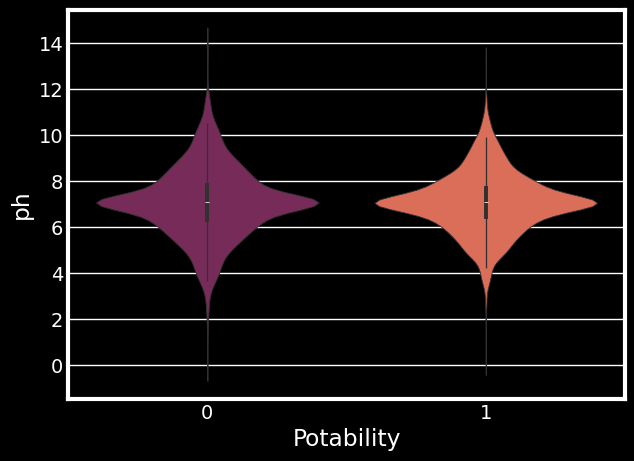

In [21]:
sns.violinplot(x='Potability', y='ph', data=df, palette='rocket')

Boxplot and density distribution of different features by Potability



ValueError: The following variable cannot be assigned with wide-form data: `hue`

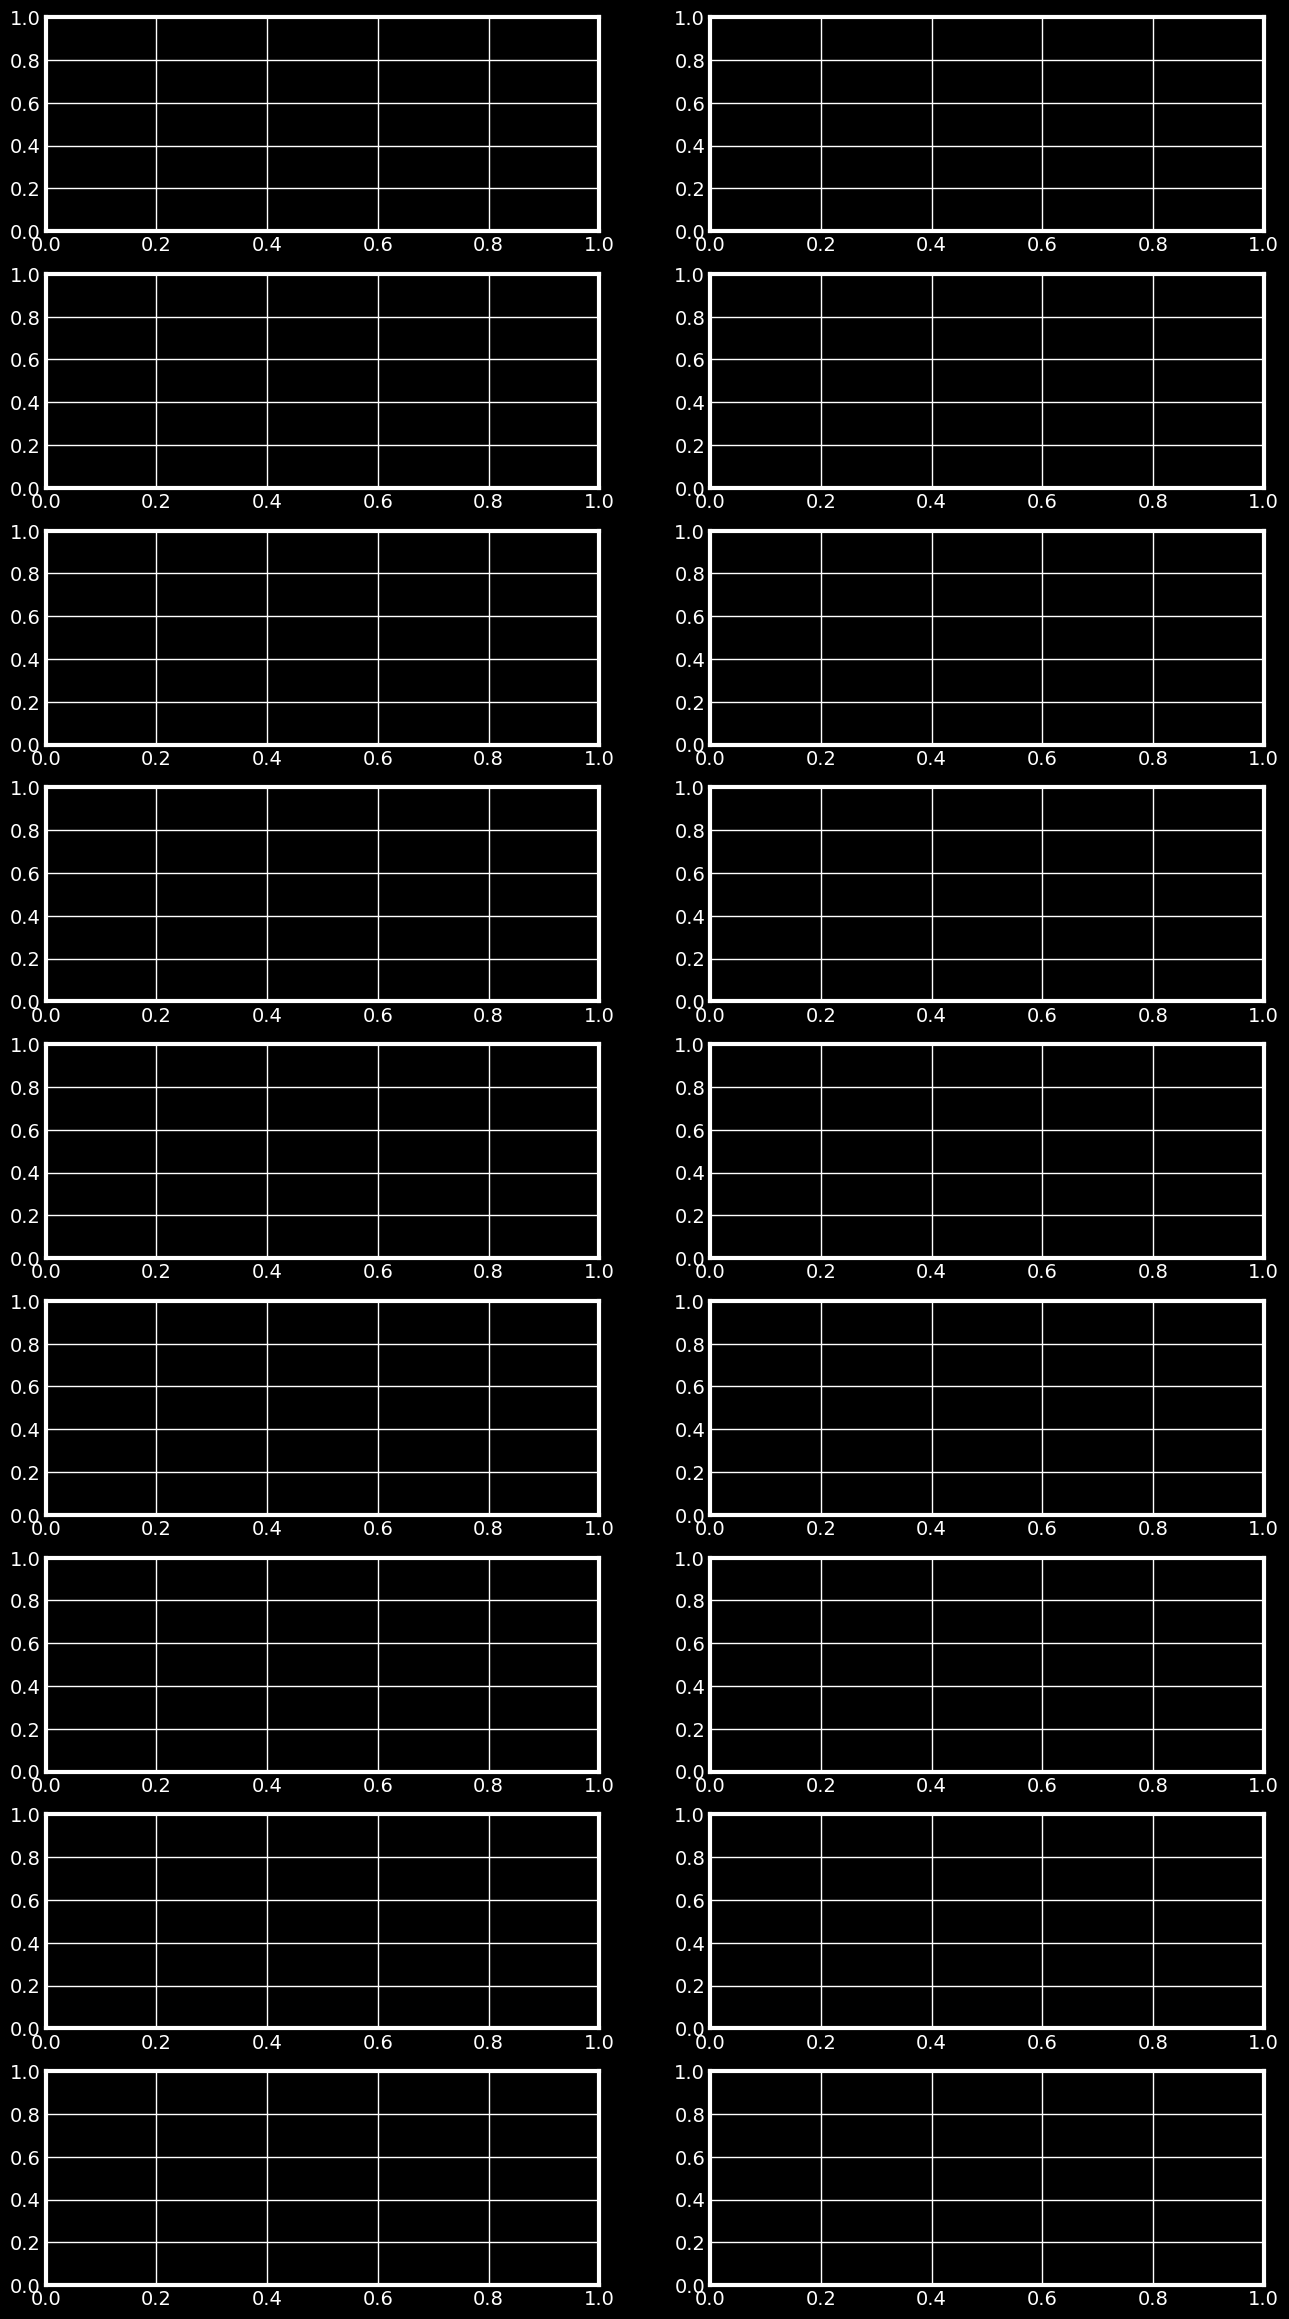

In [22]:
print('Boxplot and density distribution of different features by Potability\n')

fig, ax = plt.subplots(ncols=2, nrows=9, figsize=(14, 28))

features = list(df.columns.drop('Potability'))
i=0
for cols in features:
    sns.kdeplot(df[cols], fill=True, alpha=0.4, hue = df.Potability,
                palette=('indianred', 'steelblue'), multiple='stack', ax=ax[i,0])

    sns.boxplot(data= df, y=cols, x='Potability', ax=ax[i, 1],
               palette=('indianred', 'steelblue'))
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    ax[i,0].tick_params(left=False, labelleft=False)
    ax[i,0].set_ylabel(cols, fontsize=16)
    i=i+1

plt.show()

## SMOTE

In [37]:
##################### Preparing the Data for Modelling ######################

X = df.drop('Potability', axis = 1).copy()
y = df['Potability'].copy()

############################# Train-Test split ############################
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
# Save X_test and y_test as CSV files
X.to_csv('X_test.csv', index=False)
y.to_csv('y_test.csv', index=False)

########################## Synthetic OverSampling ###########################
print('Balancing the data by SMOTE - Oversampling of Minority level\n')
smt = SMOTE()
counter = Counter(y_train)
print('Before SMOTE', counter)
X_train, y_train = smt.fit_resample(X_train, y_train)
counter = Counter(y_train)
print('\nAfter SMOTE', counter)

################################# Scaling #################################
ssc = StandardScaler()

X_train = ssc.fit_transform(X_train)
X_test = ssc.transform(X_test)

modelAccuracy = list()

Balancing the data by SMOTE - Oversampling of Minority level

Before SMOTE Counter({0: 1488, 1: 969})

After SMOTE Counter({0: 1488, 1: 1488})


In [38]:
files.download('X_test.csv')
files.download('y_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelling and Prediction

In [24]:
model = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(),
        svm.LinearSVC(), XGBClassifier()]
trainAccuracy = list()
testAccuracy = list()
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

for mdl in model:
    trainResult = cross_val_score(mdl, X_train, y_train, scoring='accuracy', cv=kfold)
    trainAccuracy.append(trainResult.mean())
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    testResult = metrics.accuracy_score(y_test, y_pred)
    testAccuracy.append(testResult)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: Convergen

In [25]:
print('The comparision\n')
modelScore = pd.DataFrame({'Model' : model, 'Train_Accuracy' : trainAccuracy, 'Test_Accuracy' : testAccuracy})
modelScore

The comparision



,Model,Train_Accuracy,Test_Accuracy
0,LogisticRegression(),0.488873,0.518926
1,DecisionTreeClassifier(),0.716307,0.710623
2,GaussianNB(),0.557934,0.575092
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.789756,0.778999
4,LinearSVC(),0.488872,0.518926
5,"XGBClassifier(base_score=None, booster=None, c...",0.784355,0.775336


Random Forest Classifier

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       514
           1       0.70      0.78      0.74       305

    accuracy                           0.79       819
   macro avg       0.78      0.79      0.78       819
weighted avg       0.80      0.79      0.80       819

None


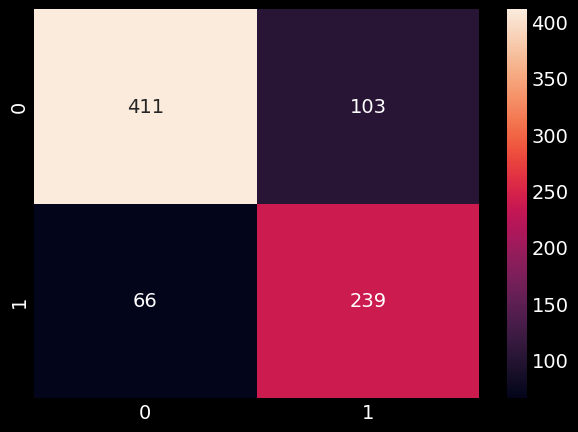

In [26]:
print('Random Forest Classifier\n')
Rfc = RandomForestClassifier()
Rfc.fit(X_train, y_train)

y_Rfc = Rfc.predict(X_test)
print(metrics.classification_report(y_test, y_Rfc))
print(modelAccuracy.append(metrics.accuracy_score(y_test, y_Rfc)))

sns.heatmap(confusion_matrix(y_test, y_Rfc), annot=True, fmt='d')
plt.show()

XGB Classifier

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       514
           1       0.67      0.78      0.72       305

    accuracy                           0.78       819
   macro avg       0.76      0.78      0.77       819
weighted avg       0.79      0.78      0.78       819

None


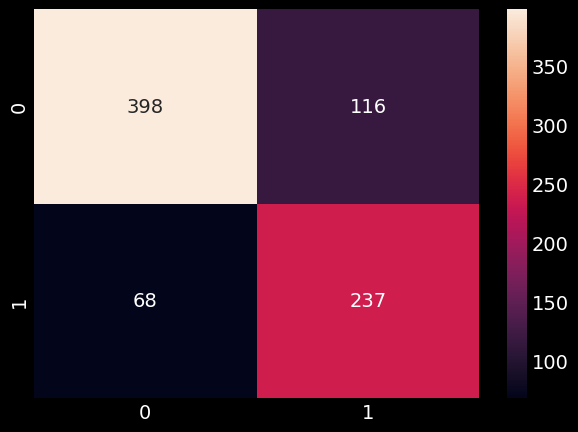

In [27]:
#################################### XGB Classifier() #######################
print('XGB Classifier\n')
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_xgb = xgb.predict(X_test)
print(metrics.classification_report(y_test, y_xgb))
print(modelAccuracy.append(metrics.accuracy_score(y_test, y_xgb)))

sns.heatmap(confusion_matrix(y_test, y_xgb), annot=True, fmt='d')
plt.show()


### Conclusion


   - The Solid levels seem to contain some descripency since its values are on an average 40 folds more than the upper limit for safe drinking water.(Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.)

   - The data contains almost equal number of acidic and basic pH level water samples.

   - The correlation coefficients between the features were very low.

   - Random Forest and XGBoost worked the best to train the model, both gives us f1 score (Balanced with precision & recall) as around 76%.


In [28]:
!pip install joblib

In [29]:
from joblib import dump, load

# Train and save the RandomForestClassifier
print('Random Forest Classifier\n')
Rfc = RandomForestClassifier()
Rfc.fit(X_train, y_train)
dump(Rfc, 'random_forest_classifier.joblib')  # Save the model

# Train and save the XGBClassifier
print('XGB Classifier\n')
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
dump(xgb, 'xgb_classifier.joblib')  # Save the model

Random Forest Classifier

XGB Classifier



['xgb_classifier.joblib']

In [31]:
from joblib import dump

# Assuming Rfc and xgb are your trained models
dump(Rfc, 'random_forest_classifier.joblib')
dump(xgb, 'xgb_classifier.joblib')

['xgb_classifier.joblib']

In [32]:
from google.colab import files

# Download the saved models to your local system
files.download('random_forest_classifier.joblib')
files.download('xgb_classifier.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
pip install scikit learn

ERROR: Could not find a version that satisfies the requirement scikit (from versions: none)
ERROR: No matching distribution found for scikit


In [34]:
pip install scikit-learn==1.2.2

In [35]:
# Re-train the model with the current scikit-learn version
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Save the newly trained model
dump(rfc, 'random_forest_classifier.joblib')

['random_forest_classifier.joblib']